In [191]:
import pandas as pd
import numpy as np 
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as ss
import warnings
warnings.filterwarnings("ignore")
import tabulate

# Contents
### Modelling CVA & DVA for Options and Forward

### 1 : Monte Carlo for Option's CVA & DVA :: Reference John C Hull
    1 : Basic Model for CVA Pricing
        Inputs : Random Scenario Generator ( GBM and Heston Based ), historical moments used for 'P' measure.
        b) Credit Spread of the companies used as risk neutral pricing measure.
        c) Recovery Rate assumption : 40 %
        d) Black scholes pricing used with plain vanilla equity option as derivative
           >> Risk Neutral Pricing used & Risk Horizon 256 days
    
    2: Basic Modelling for Credit VaR
        Inputs : Random Scenario Generator ( GBM and Heston Based).
        b) Default Threshold Indicator function (Assumption of Default 15% appreciation in Price of portfolio).
        c) Pnl distribution
         
    Reference : John C Hull, Assumption Pricing 1 Options contract, with underlying of 1 unit.
### 2 : Merton Inspired Model for Forward CVA & DVA :: Reference John C Hull
    1 : The method is inspired from John C hull book, to calculate the value of CVA and DVA for uncollateralised transaction of
        forward contract.
        a) Predefined PD measure used.
        b) Recovery Rate assumption : 30 %
        c) Dummy values used for sigma, mu, forward and strike price.
        d) Default assumption is mid of the month.

    

#### Monte carlo Method to Calculate CVA and DVA for Plain Vanilla Option

In [231]:
data=pd.read_csv("C:\\Users\Lenovo\Desktop\RWE\codes\data_1.csv",index_col=0,header=0,parse_dates=True)

lenght=len(data)

recovery = 0.4

def option_price(S_O=42,K=48,riskfreerate=0.1,vol=0.2,time=(lenght/252),call=True):
    d_1=(np.log(S_O/K) + (riskfreerate + vol**2/2)*time)/(vol * time**0.5)
    d_2=d_1 - vol*time**0.5
    if call == True: # Price of European Call Option
        call_price= S_O * ss.norm.cdf(d_1) - ss.norm.cdf(d_2) * K * np.exp(-riskfreerate* time)
        return round(call_price,2)
    else: # Price of European Put Option
        put_price= ss.norm.cdf(-d_2) * K * np.exp(-riskfreerate* time) - S_O * ss.norm.cdf(-d_1)
        return round(put_price,2)

def scenario_generator(start=42,mu=0.050,sigma=0.20,total=lenght,scenario=500):  # Input Mu and Sigma as annualised values and total in months, as risk horizon
    dt=1/total
    df=pd.DataFrame(np.random.normal(loc=mu*dt,scale=sigma*np.sqrt(dt),size=(total+1,scenario)))
    df.iloc[0]=0
    df=start*(1+df).cumprod()
    return df


simulation=scenario_generator()


price_df=pd.DataFrame()
for i in range(len(data)):
    price=pd.DataFrame(option_price(S_O=simulation.iloc[i],time=((len(data)-i)/252))).T
    price_df=price_df.append(price)
price_simulation=price_df

exposure=[]
for i in range(len(price_simulation)-1):
    f1=pd.DataFrame(np.where(price_simulation.iloc[i+1]>price_simulation.iloc[0,0],price_simulation.iloc[i+1],np.nan)).sort_values(by=0).dropna()
    f1=f1.reset_index()
    f1['Prob']=f1['index']/500
    expected_exposure=((f1[0]*f1['Prob']).sum())/len(f1) #positive expected exposure 
    fpe=np.percentile(price_simulation.iloc[i+1],99)
    exposure.append([fpe,expected_exposure,expected_exposure*(1-recovery),i+1])

exposure_profile=pd.DataFrame(exposure)

exposure_profile.columns=['Future Potential Exposure at 99% percentile','Expected Exposure','Expected Loss','Timeline']

data=data.iloc[:-1]

data['PD']=np.exp(-((data['Spread'] * data['Timeline'])/(1-recovery)))
data['Per period PD']=-data['PD'].diff().shift(-1)
data['Per period PD']=np.where(data['Per period PD']<0,0,data['Per period PD'])
exposure_profile['Mid Market Expected Loss']=(exposure_profile['Expected Loss'].shift(-1) + exposure_profile['Expected Loss'])/2
cva=((data['Per period PD']*data['Discount Factor']) * exposure_profile['Mid Market Expected Loss'].values).sum()

exposure_dva=[]
for i in range(len(price_simulation)-1):
    f1_d=pd.DataFrame(np.where(price_simulation.iloc[i+1]<price_simulation.iloc[0,0],price_simulation.iloc[i+1],np.nan)).sort_values(by=0).dropna()
    f1_d=f1_d.reset_index()
    f1_d['Prob']=f1_d['index']/500
    expected_exposure_d=((f1_d[0]*f1_d['Prob']).sum())/len(f1_d) #positive expected exposure 
    fpe_d=np.percentile(price_simulation.iloc[i+1],1)
    exposure_dva.append([fpe_d,expected_exposure_d,expected_exposure_d*(1-recovery),i+1])
dva_profile=pd.DataFrame(exposure_dva,columns=['Future Potential Exposed','Expected Exposed','Expected Pay','Timeline'])
data_dva=data
data_dva['DVA_PD']=data_dva['Per period PD']*(1-0.05)
dva_profile['Mid Market Expected Loss']=(dva_profile['Expected Pay'].shift(-1) + dva_profile['Expected Pay'])/2
dva=((data_dva['DVA_PD']*data['Discount Factor']) * dva_profile['Mid Market Expected Loss'].values).sum()
risk_price=price_simulation.iloc[0,0]-dva+cva
print("================================================"+ '\n')
print('########### The Value of CVA (Charged at Beginning) : ' + str(round(cva,2)) + '\n')
print('########### The Value of DVA (Charged at Beginning) : ' + str(round(dva,2)) + '\n')
print('########### The Risk Free Value of Option under Q measure : ' + str(round(price_simulation.iloc[0,0],2)) + '\n')
print('########### The Price of Option under Q measure including CVA & DVA adjustment is  : ' + str(round(risk_price,2)) + '\n')
print("================================================")


initial=0
rolling_cva=pd.DataFrame()
for i in range(32):
    last=initial + 8
    cut=pd.DataFrame(data['Euro Risk Free'].iloc[initial : last])
    p_d=pd.DataFrame(data['Per period PD'].iloc[initial : last])
    valuation=pd.DataFrame(exposure_profile['Mid Market Expected Loss'].iloc[initial: last])
    initial=last
    cut['time']=np.arange(1,9)
    cut['DF']=1/(1+cut['Euro Risk Free'])**cut['time']
    discount_loss=pd.DataFrame((valuation['Mid Market Expected Loss']*cut['DF'].values))
    cva_rol=pd.Series(round((discount_loss*p_d.values).sum()[0],5))
    #print(cva_rol)
    rolling_cva=rolling_cva.append(cva_rol,ignore_index=True)
rolling_cva.columns=['Rolling CVA Charged every 8th Day']

pnl=with_default_scenario_1-price_simulation.iloc[0].values


stat=pd.DataFrame(data=[round((with_default_scenario_1-price_simulation.iloc[0].values).mean(),1),
                    
                    round((with_default_scenario_1-price_simulation.iloc[0].values).std(),1),
                    
                    round(np.percentile((with_default_scenario_1-price_simulation.iloc[0].values),99),1),
                    
                    round(np.percentile((with_default_scenario_1-price_simulation.iloc[0].values),1),1),
                    
                    round(((np.where(price_simulation.iloc[-1]>=price_simulation.iloc[0,0],1,0).sum())/len(price_simulation.iloc[-1].index))*100,1),
                    
                    round(((np.where(price_simulation.iloc[-1]<price_simulation.iloc[0,0],1,0).sum())/len(price_simulation.iloc[-1].index))*100,1),
                        
                    round(pnl.skew(),1),

                    round(pnl.kurt(),1)],
                    
                    columns=['Statistics of the Trade'],index=['Mean Profit including Default','Standard Deviation','99th Percentile','1th Perncentile','Probabilty of going in the Money','Probabilty of being Out of Money','Skewness','Excess of Kurtosis']).T


########### The Value of CVA (Charged at Beginning) : 0.76

########### The Value of DVA (Charged at Beginning) : 0.46

########### The Risk Free Value of Option under Q measure : 2.8

########### The Price of Option under Q measure including CVA & DVA adjustment is  : 3.1



In [232]:
print(tabulate.tabulate(stat.T,headers=['Basic Statistics of Simulation','Reported Values'],tablefmt="orgtbl"))

| Basic Statistics of Simulation   |   Reported Values |
|----------------------------------+-------------------|
| Mean Profit including Default    |              -1.5 |
| Standard Deviation               |               2.8 |
| 99th Percentile                  |              11.5 |
| 1th Perncentile                  |              -2.8 |
| Probabilty of going in the Money |              24.4 |
| Probabilty of being Out of Money |              75.6 |
| Skewness                         |               3   |
| Excess of Kurtosis               |              10.7 |


<AxesSubplot:title={'center':'Profile of the Portfolio of Vanilla Options'}>

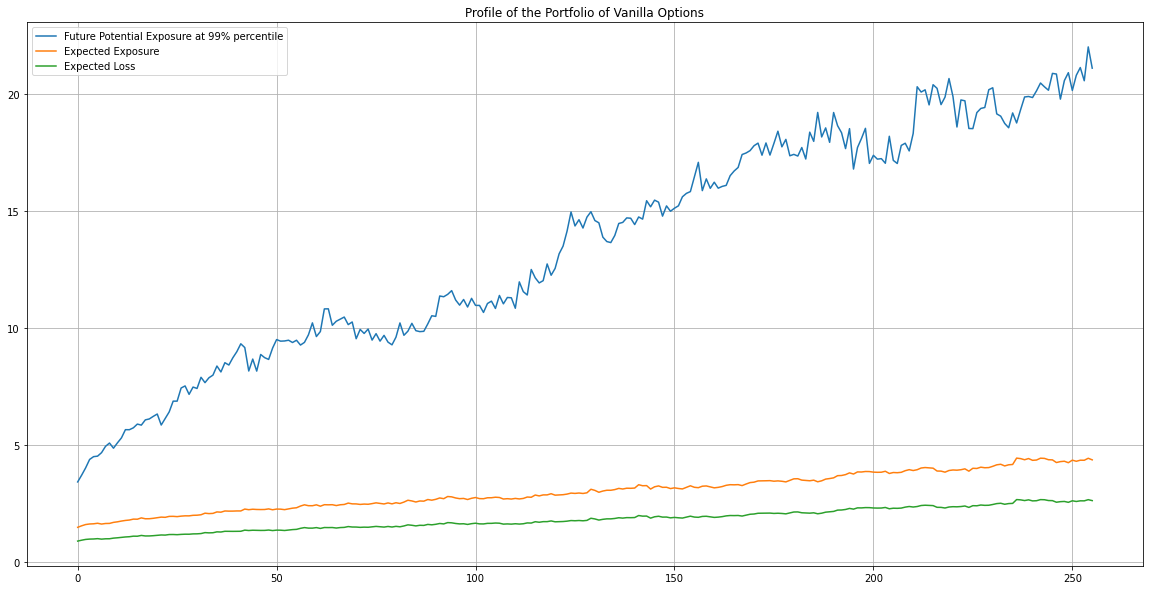

In [233]:
exposure_profile.iloc[:,:-2].plot(figsize=(20,10),grid=True,title='Profile of the Portfolio of Vanilla Options')

In [234]:
default_point_1=price_simulation.iloc[0,0]*(1+0.40)
with_default_scenario_1=pd.Series(np.where(price_simulation.iloc[-1]>default_point_1,price_simulation.iloc[-1]*(1-recovery),price_simulation.iloc[-1]))
skew=pnl.skew()
kurt=pnl.kurt()
z = ss.norm.ppf(5/100)
s = pnl.skew()
k = pnl.kurt()
z = (z +(z**2 - 1)*s/6 +(z**3 -3*z)*(k-3)/24 -(2*z**3 - 5*z)*(s**2)/36)
var= ((pnl.mean() + z*pnl.std(ddof=0)))
print("================================================"+ '\n')
print('########### The Value of VaR at begining of the Trade at 1 Percentile, with daily horizon : ' + str(round(np.percentile(with_default_scenario_1-price_simulation.iloc[0].values,1),2)) + '\n')
print('########### The Value of Cornich Fidher VaR at begining of the Trade at 1 Percentile, with daily horizon : ' + str(round(var,2)) + '\n')
print("Cornish Fisher VaR takes into account the Skewness and Kurtosis of the Distribution")
print("================================================")


########### The Value of VaR at begining of the Trade at 1 Percentile, with daily horizon : -2.8

########### The Value of Cornich Fidher VaR at begining of the Trade at 1 Percentile, with daily horizon : -2.78

Cornish Fisher VaR takes into account the Skewness and Kurtosis of the Distribution


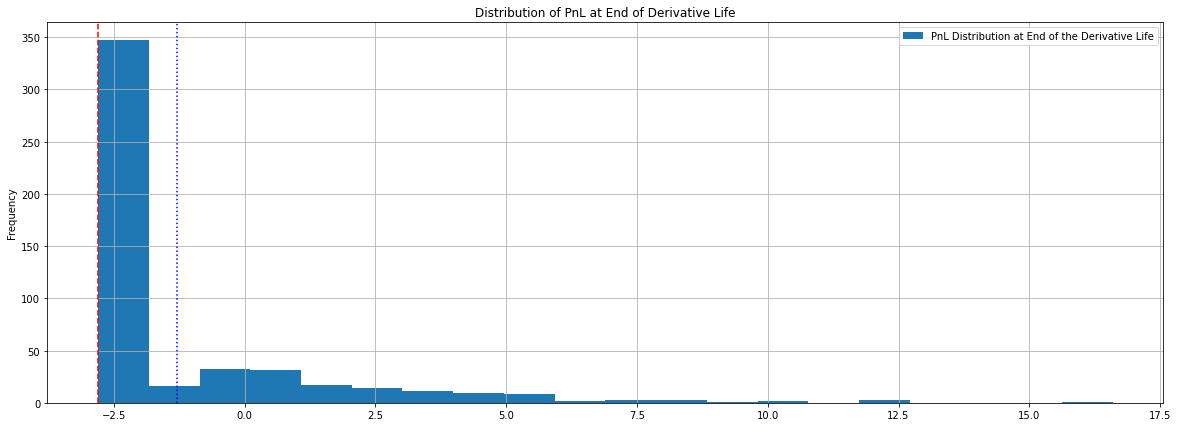

In [235]:
pd.DataFrame(with_default_scenario_1-price_simulation.iloc[0]).plot.hist(figsize=(20,7),bins=20,grid=True,title='Distribution of PnL at End of Derivative Life')
plt.axvline(x = np.percentile(with_default_scenario_1-price_simulation.iloc[0].values,1), color = 'r', label = 'VaR',linestyle='--')
plt.axvline(x = (with_default_scenario_1-price_simulation.iloc[0]).mean(), color = 'b', label = 'VaR',linestyle=':')
plt.legend(['PnL Distribution at End of the Derivative Life'])

#### Direct Formula to Calculate CVA and DVA for Forward contract 

In [236]:
def forward_adjustment(F=1600,K=1500,risk_free_rate=0.05,recov=0.3,q_1=0.001667,q_2=0.0025,total_time=24,sigma=0.2,q_bank=0.001):
    timeline=np.arange(0.5,total_time,1)  # Middle month default
    cva_f=0
    dva_f=0
    for i in timeline:
        dt=i
        d_1=(np.log(F/K) + sigma ** 2 * (dt/12) * 0.5 )/(sigma * np.sqrt(dt/12))
        d_2=d_1-sigma * np.sqrt(dt/12)
        w_t=(F*ss.norm.cdf(d_1) - K * ss.norm.cdf(d_2)) * np.exp(-risk_free_rate * (len(timeline)/12))
        if i > (len(timeline)/2 +1):
            pd=q_2
        else:
            pd=q_1
        cva_f=cva_f+w_t*(1-recov)*pd
        w_dva_t= ( K*ss.norm.cdf(-d_2) - F * ss.norm.cdf(-d_1) ) * np.exp(-risk_free_rate * (len(timeline)/12))
        dva_f= dva_f+ w_dva_t * (1-recov) * q_bank
        #print(cva,dva)
    forward_value=(F-K)*np.exp(-risk_free_rate * (total_time/12))
    rrp=forward_value + dva_f - cva_f
    print("================================================"+ '\n')
    print('########### The Value of CVA for the forward (Charged at Beginning) : ' + str(round(cva_f,2)) + '\n')
    print('########### The Value of DVA for the forward (Charged at Beginning) : ' + str(round(dva_f,2)) + '\n')
    print('########### The Risk Free Value of forward under Q measure : ' + str(round(forward_value,2)) + '\n')
    print('########### The Price of forward under Q measure including CVA & DVA adjustment is  : ' + str(round(rrp,2)) + '\n')
    print("================================================")
forward_adjustment()


########### The Value of CVA for the forward (Charged at Beginning) : 5.63

########### The Value of DVA for the forward (Charged at Beginning) : 1.13

########### The Risk Free Value of forward under Q measure : 90.48

########### The Price of forward under Q measure including CVA & DVA adjustment is  : 85.99

